# **Calculating Stoner-Wohlfarth Curves**

The Stoner-Wohlfarth model is given in the paper "A Mechanism of Magnetic Hysteresis in Heterogeneous Alloys":

> [E.C. Stoner and E.P. Wohlfarth, Phil. Trans. Royal Soc. London 240 (1948) 599](https://doi.org/10.1098/rsta.1948.0007)

<br>

- The SW-model considers magnetisation processes governed by **<font color=red>rotations</font>**  of the magnetisation vector.
- Magnetisation processes based on domains and domain wall movement are **NOT** considered.

The model is therefore strictly valid for:
- single-domain particles ($d < d_{c}$) or 
- ensembles of non-interacting, single-domain particles

But we can also apply the SW-model in cases where *domain wall motion is not relevant*:
- hard axis magnetisation curve of a single crystal with uniaxial anisotropy
- magnetisation curve of a polyscrystal at applied field strengths above those where domain wall movement occurs (neglecting particle-particle interactions).



<br>

Consider a single-domain particle with uniaxial magnetocrystalline anisotropy.

- In zero applied field, $H$, the magnetisation, $M_{0}$, will be parallel to the easy axis.

- If we apply a field, $H$, perpendicular to the easy axis, $M_{0}$ will be forced to rotate away from the easy axis, towards $H$.

<img src="resources/SW-angles-schematic.png" width="400" align="left"/>

<br>

The angle between the field and the magnetisation, $\theta_{M}$, results from miminising the sum of the **anisotropy energy** and the **Zeeman (field) energy**:

## $E_{v} = K_{1}sin^{2}(\theta_{M}-\theta_{H})  + K_{2}sin^{4}(\theta_{M}-\theta_{H}) - M_{0}Hcos{\theta_{M}}$

where:

$E_{v}$ = the total energy per unit volume

$M_{0}$ = the spontaneous magnetisation of the material

$K_{1}$, $K_{2}$ = second and fourth order magnetocrystalline anisotropy constants

$\theta_{H}$ = angle between the applied field and the easy axis

$\theta_{M}$ = angle between the applied field and the magnetisation

$H$ = applied field strength

<br>

Before we can write down the equation in code, we need to import some things we will need:

In [11]:
import numpy
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from scipy.optimize import minimize
import ipywidgets as widgets
from ipywidgets import interactive, fixed

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.rc('font', size=10)
plt.rc('figure', figsize=(6,4))

In [12]:
def get_energy_terms(thetaM, thetaH, H, M0, K1, K2):
    """
    Calculate the anisotropy energy, the Zeeman energy and the total energy, given
    the arguments.
    
    Args:
        thetaM = angle in degrees between the magnetisation and the applied field
        thetaH = angle in degrees between the easy axis and the applied field
        H = applied field in Oe
        M0 = spontaneous magnetisation in erg/Oe.cm^3 (== kA/m)
        K1 = second order anisotropy constant in erg/cm^3
        K2 = fourth order anisotropy constant in erg/cm^3
    
    Returns: 
        AE = float, the anisotropy energy per unit volume for the conditions given, unit: erg/cm^3.
        ZE = float, the Zeeman energy per unit volume for the conditions given, unit: erg/cm^3.
        TE = float, the total energy per unit volume for the conditions given, unit: erg/cm^3.
    """
    t1 = K1*numpy.sin(numpy.deg2rad(thetaM-thetaH))**2
    t2 = K2*numpy.sin(numpy.deg2rad(thetaM-thetaH))**4

    AE = t1+t2
    ZE = M0*H*numpy.cos(numpy.deg2rad(thetaM))
    TE = AE-ZE
    
    return AE, ZE, TE

<br>

### Example with $Y_{2}Fe_{14}B$
This material has a tetragonal crystal structure and uniaxial magnetocrystalline anisotropy, where the <001> axis is the easy axis.

Here are values for for the constants for $Y_{2}Fe_{14}B$ extracted from [Givord *et al.* Solid State Comm. 51 (1984) 857-860](https://doi.org/10.1016/0038-1098(84)91087-1).

In [13]:
M0 = 1053 # erg/Oecm^3 == kA/m (~ 1.4 T )
K1 = 1.25e7 # erg/cm^3 
K2 = 0.05e7 # erg/cm^3 

Let's examine how the energy per unit volume, $E_{v}$, changes as a function of the angle between the field and the magnetisation, $\theta_{M}$ for different applied field strengths, $H$, using an interactive plot.

In [14]:
def plot_func(thetaH, H, M0, K1, K2):
    thetaM = numpy.arange(91)
    AE, ZE, TE = get_energy_terms(thetaM, thetaH, H, M0, K1, K2)
    
    fig, ax = plt.subplots()
    
    ax.plot(thetaM, AE, 'b-', lw=2.0, label='Anisotropy Energy')
    ax.plot(thetaM, ZE, 'r-', lw=2.0, label='Zeeman Energy')
    ax.plot(thetaM, TE, 'g-', lw=2.0, label='Total Energy')

    ax.grid(which="major")
    ax.set_xlabel(r"$\theta_{M} \ /\ \degree$")
    ax.set_ylabel(r"$E_{v}\ /\ erg \cdot cm^{-3}$")
    ax.legend(loc="upper right")
    ax.set_xlim(xmin=0.0, xmax=90.0)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x: ,.2e}'))


    
interactive_plot = interactive(plot_func, thetaH=[90,0], 
                               H=widgets.IntSlider(value=0.0, min=0.0, max=28000, 
                                                   step=1000, description="H / Oe"),
                               M0=fixed(M0), K1=fixed(K1), K2=fixed(K2))

output = interactive_plot.children[-1]
output.layout.height = '360px'
interactive_plot

interactive(children=(Dropdown(description='thetaH', options=(90, 0), value=90), IntSlider(value=0, descriptio…

Let's redefine our fuction so that it only returns the total energy (we don't need the other terms individually now):

In [15]:
def SW_E(thetaM, thetaH, H, M0, K1, K2):
    """
    Calculate the energy per unit volume resulting from the
    balance of the anisotropy energy and Zeeman energy, given
    the arguments.
    
    Args:
        thetaM = angle in degrees between the magnetisation and the applied field
        thetaH = angle in degrees between the easy axis and the applied field
        H = applied field in Oe
        M0 = spontaneous magnetisation in erg/Oe.cm^3 (== kA/m)
        K1 = second order anisotropy constant in erg/cm^3
        K2 = fourth order anisotropy constant in erg/cm^3
    
    Returns: 
        E = float, the energy per unit volume for the conditions given, unit: erg/cm^3.
    """
    t1 = K1*numpy.sin(numpy.deg2rad(thetaM-thetaH))**2
    t2 = K2*numpy.sin(numpy.deg2rad(thetaM-thetaH))**4
    t3 = M0*H*numpy.cos(numpy.deg2rad(thetaM))
    return t1+t2-t3

We can use `scipy.optimize.minimize` to find the minimum of $E_{v}$ for a particular applied field and angle $\theta_{H}$ like this:

In [16]:
q = minimize(SW_E, 90, args=(90, 8000, M0, K1, K2), method="Nelder-Mead")

In [17]:
q

 final_simplex: (array([[70.48951721],
       [70.48944855]]), array([-1412943.63468444, -1412943.63468102]))
           fun: -1412943.6346844418
       message: 'Optimization terminated successfully.'
          nfev: 40
           nit: 20
        status: 0
       success: True
             x: array([70.48951721])

In [18]:
q.x[0]

70.48951721191406

<br>

We can use `scipy.optimize.minimize` in a **loop** to find the minimum of $E_{v}$ for a several applied field values like this:

In [19]:
def getData_single(FR, M0, K1, K2, thetaH):
    """
    For each value of the field in the field range (FR), find the minimum
    of the absolute value of the derivative of the energy equation with
    respect to the angle theta.
    
    Args:
        FR : array of applied field values in Oe
        thetaH = angle in degrees between the easy axis and the applied field
        M0 = spontaneous magnetisation in erg/Oe.cm^3 (== kA/m)
        K1 = second order anisotropy constant in erg/cm^3
        K2 = fourth order anisotropy constant in erg/cm^3
        
    Returns:
        D : a list of angles thetaM in degrees at which the derivative of the energy
            equation is zero for the field values defined in FR
    """
    D = []
    IG = thetaH
    for H in FR:
        q = minimize(SW_E, IG, args=(thetaH, H, M0, K1, K2), method="Nelder-Mead")
        D.append(q.x[0])
        IG = q.x[0]

        
    return D

In [20]:
# field range (start, stop, step) in Oe
FR = numpy.arange(0, 6.6e4, 1.0e3)

In [21]:
D = getData_single(FR, M0, K1, K2, 90.0)

Now,  $\cos\theta_{M} = \frac{M}{M_{0}}$, so to plot M(H) we need to multiply cosine of the angles, $\theta$ in D by $M_{0}$

Text(32000, 800, '$\\mathregular{H = \\frac{2(K_{1} + 2K_{2})}{M_{0}}}}$')

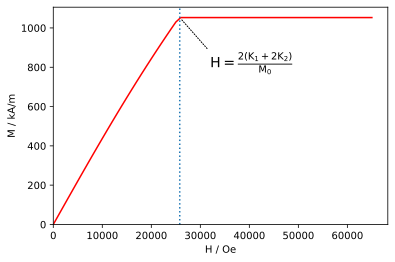

In [44]:
plt.plot(FR, numpy.cos(numpy.deg2rad(D))*M0, 'r-')
plt.xlabel("H / Oe")
plt.ylabel("M / kA/m")
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.axvline(x=25800, ls=':')
plt.annotate(r"$\mathregular{H = \frac{2(K_{1} + 2K_{2})}{M_{0}}}}$", (25800, 1053), (32000, 800), 
             arrowprops={"arrowstyle" : "-", "relpos" : (0,1), "ls" : ':'}, fontsize=14)

Experimental results for a $Y_{2}Fe_{14}B$  single crystal were measured by [Givord *et al.* Solid State Comm. 51 (1984) 857-860](https://doi.org/10.1016/0038-1098(84)91087-1).

Two text files containing experimental data points extracted from the above paper are in the folder "resources" and can be loaded using  `numpy.loadtxt`.

In [30]:
# load Givord's measurements of a Y2Fe14B SX at 300K

Ge = numpy.loadtxt("resources/Givord_Y2Fe14B_001_conv.txt")
Gh = numpy.loadtxt("resources/Givord_Y2Fe14B_100_and_110_conv.txt")

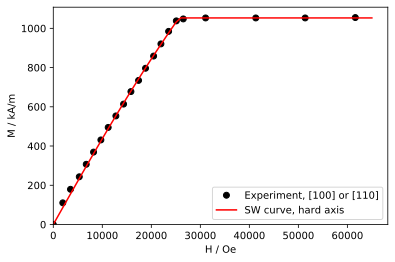

In [31]:
plt.plot(Gh[:,0],Gh[:,1],'ko', label="Experiment, [100] or [110]")
plt.plot(FR, numpy.cos(numpy.deg2rad(D))*M0, 'r-', label="SW curve, hard axis")
plt.xlabel("H / Oe")
plt.ylabel("M / kA/m")
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.legend()

We have very good agreement between the experimentally measured data for a single crystal and our calculated Stoner-Wohlfarth curve.

<br>

Now we can use the same code to calculate an easy axis curve to compare with the experimental data:

In [32]:
D1 = getData_single(FR, M0, K1, K2, 0.0)

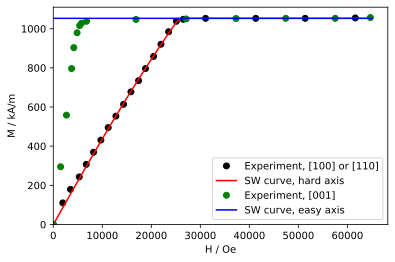

In [33]:
plt.plot(Gh[:,0],Gh[:,1],'ko', label="Experiment, [100] or [110]")
plt.plot(FR, numpy.cos(numpy.deg2rad(D))*M0, 'r-', label="SW curve, hard axis")
plt.plot(Ge[:,0],Ge[:,1],'go', label="Experiment, [001]")
plt.plot(FR, numpy.cos(numpy.deg2rad(D1))*M0, 'b-', label="SW curve, easy axis")

plt.xlabel("H / Oe")
plt.ylabel("M / kA/m")
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.legend()

The discrepancy between the SW-curve for the easy axis and the experimental data at fields below ~ 5000 Oe is due to the formation of domains in the sample. Domains are not accounted for in the Stoner-Wohlfarth model.